In [26]:
import os
import sys
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
sys.path.insert(1, os.path.realpath(os.path.join(sys.path[0], os.pardir, os.pardir)))
from frequency_response import FrequencyResponse
from constants import ROOT_DIR
DIR_PATH = os.path.join(ROOT_DIR, 'research', 'peq_optimizer')

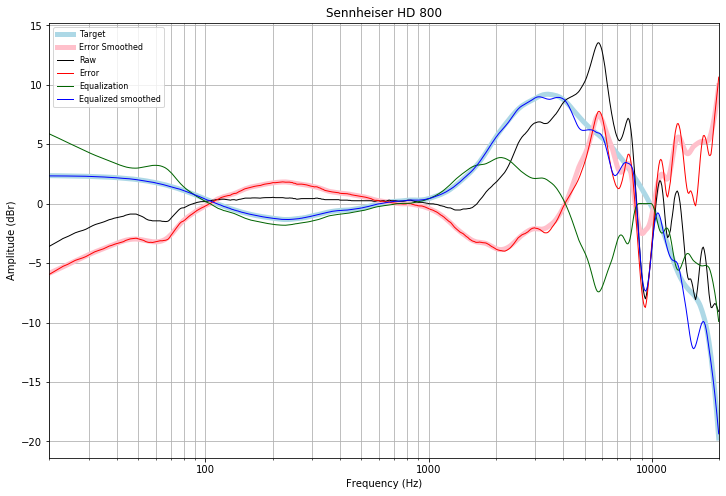

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x168cc9a4888>)

In [27]:
hd800 = FrequencyResponse.read_from_csv(os.path.join(ROOT_DIR, 'results', 'oratory1990', 'harman_over-ear_2018', 'Sennheiser HD 800', 'Sennheiser HD 800.csv'))
hd800.interpolate()
hd800.plot_graph(show=True)

In [28]:
# Read equalization curves from results as data
# TODO: Create data generator for unlimited data
if os.path.isfile(os.path.join(DIR_PATH, 'data.npy')):
    # Saved previously to numpy file
    data = np.load(os.path.join(DIR_PATH, 'data.npy'))
else:
    # Not saved, read frequency response CSVs
    data = []
    for fp in glob(os.path.join(ROOT_DIR, 'results', '**', '*.csv'), recursive=True):
        fr = FrequencyResponse.read_from_csv(fp)
        fr.interpolate()
        data.append(fr.equalization)
    data = np.vstack(data)
    np.save(os.path.join(DIR_PATH, 'data.npy'), data)
    
# Split data into training and testing
n_train = int(len(data) * 0.8)
n_test = len(data) - n_train
x_train = data[:n_train]
y_train = x_train.copy()
x_test = data[n_train:]
y_test = x_test.copy()

In [39]:
# Build model architecture
# TODO: tweak hyperparameters such as number of hidden layers and number of nodes in each layer
inputs = keras.Input(shape=hd800.frequency.shape[0])  # Input layer, take size from HD 800 FrequencyResponse above
x = layers.Dense(64, activation='relu')(inputs)  # First hidden layer
x = layers.Dense(64, activation='relu')(x)  # Second hidden layer
outputs = layers.Dense(60)(x)  # Output layer: 20 filters with 3 parameters each
model = keras.Model(inputs=inputs, outputs=outputs, name='peq')
model.summary()

Model: "peq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 695)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                44544     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 60)                3900      
Total params: 52,604
Trainable params: 52,604
Non-trainable params: 0
_________________________________________________________________


In [40]:
lr = 0.001  # TODO: Find suitable learning rate for fast convergence
fs = 48000.0
n_filters = 10
frequency = hd800.frequency.copy()
f = tf.constant(np.repeat(np.expand_dims(frequency, axis=0), 20, axis=0), name='f', dtype='float32')


def loss(eq_fr_target, eq_parameters):
    """Loss function. Calculates frequency response of a parametric equalizer which has 20 filters with Fc, Q and gain given as y_pred
    
    Args:
        eq_target: Target vector for the equalizer frequency response
        eq_parameters: Predicted parametric eq parameters as 60 dimenstional vector with 20 3 parameter groups
        
    Returns:
        Loss value
    """
    # Reshape 60 dimensional vector to 20 by 3 matrix
    filters = tf.reshape(eq_parameters, (tf.size(eq_parameters) / 60, 20, 3))  # Each row contains Fc, Q and gain
    # Calculate frequency response from the predicted parameters
    # Parametric equalizers use biquad filters for which frequency response can be calculated from zero-pole presentation
    # Calculate a and b coefficients first
    # https://en.wikipedia.org/wiki/Digital_biquad_filter
    A = 10 ** (filters[:, :, 2:3] / 40)  # Range for second index is necessary to prevent tensor from being squeezed
    w0 = 2 * np.pi * tf.pow(10.0, filters[:, :, 0:1]) / fs  # Range for second index is necessary to prevent tensor from being squeezed
    alpha = tf.sin(w0) / (2 * filters[:, :, 1:2])  # Range for second index is necessary to prevent tensor from being squeezed

    a0 = (1 + alpha / A)
    a1 = -(-2 * tf.cos(w0)) / a0
    a2 = -(1 - alpha / A) / a0

    b0 = (1 + alpha * A) / a0
    b1 = (-2 * tf.cos(w0)) / a0
    b2 = (1 - alpha * A) / a0
    
    w = 2 * np.pi * f / fs
    phi = 4 * tf.sin(w / 2) ** 2

    a0 = 1.0  # Normalized form
    a1 *= -1
    a2 *= -1

    # Equalizer frequency response from a and b coefficients
    eq_fr = 10 * tf.math.log((b0 + b1 + b2) ** 2 + (b0 * b2 * phi - (b1 * (b0 + b2) + 4 * b0 * b2)) * phi) / tf.math.log(10.0)  # TF has no log10
    eq_fr -= 10 * tf.math.log((a0 + a1 + a2) ** 2 + (a0 * a2 * phi - (a1 * (a0 + a2) + 4 * a0 * a2)) * phi) / tf.math.log(10.0)  # TF has not log10
    # Total equalizer frequency response is the sum of all 20 filter frequency responses
    eq_fr = tf.reduce_sum(eq_fr, axis=1)

    # MSE as loss
    # Equalizer frequency response should be zero
    l = tf.reduce_mean(tf.square(eq_fr - eq_fr_target))
    # Penalize for last 10 filters having gain >= 0
    #l += tf.abs(filters[:, n_filters:, 2]) * maaginen_k
    # Penalize for having gain > +-12 dB
    #l += filter[:, :, tf.abs(filter[:, :, 2]) > 12] * maaginen_l
    return l


model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=lr))

In [41]:
# TODO: It would be better to generate data between epochs?
history = model.fit(
    x_train, y_train,
    batch_size=64,  # TODO: Adjust batch size for better performance, bigger batch size runs faster
    epochs=5,  # TODO: Adjust this
    validation_split=0.2
)

Train on 2593 samples, validate on 649 samples
Epoch 1/5
2593/2593 [==============================] - 3s 1ms/sample - loss: nan - val_loss: nan
Epoch 2/5
2593/2593 [==============================] - 1s 567us/sample - loss: nan - val_loss: nan
Epoch 3/5
2593/2593 [==============================] - 2s 589us/sample - loss: nan - val_loss: nan
Epoch 4/5
2593/2593 [==============================] - 1s 546us/sample - loss: nan - val_loss: nan
Epoch 5/5
2593/2593 [==============================] - 1s 524us/sample - loss: nan - val_loss: nan


In [ ]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores)

In [42]:
params = model.predict(x_test[0:1])  # Index range is needed because model expects a batch instead of a single vector
print(np.reshape(params, (20, 3)))

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
